# Text Classification with WOE

In this notebook, we are building a simple, transparent, and interpretable text classification model using Weight-of-Evidence (WOE).

WOE transformation provides an interpretable score for each word or token, reflecting how much evidence that token provides for predicting the target variable. This makes the model’s decision-making process clear and easy to explain.

Since text data in the example is categorical (each word is a category), the WOE approach is naturally suited to this type of data. It transforms words into numerical scores that a linear model can easily use.

Author: https://www.github.com/deburky

Further reading
---

David Alvarez-Melis et al. From Human Explanation to Model Interpretability: A Framework Based on Weight of Evidence. © 2021, Association for the Advancement of Artificial Intelligence ([www.aaai.org](www.aaai.org)).

* [ArXiv](https://arxiv.org/abs/2104.13299)
* [interpretwoe](https://github.com/dmelis/interpretwoe)

## Import data

Dataset composed of online banking queries annotated with their corresponding intents.

BANKING77 dataset provides a very fine-grained set of intents in a banking domain. It comprises 13,083 customer service queries labeled with 77 intents. It focuses on fine-grained single-domain intent detection.

In [1]:
import pandas as pd

splits = {"train": "data/train-00000-of-00001.parquet", "test": "data/test-00000-of-00001.parquet"}
df = pd.read_parquet("hf://datasets/legacy-datasets/banking77/" + splits["train"])

df = df.sample(frac=1, random_state=0).reset_index(drop=True)

n_of_labels = len(df["label"].unique())
print(n_of_labels)

77


## WOE Text Classification Model

$WOE = ln(\frac{P{(Y=1)}}{P{(Y=0)}})$

WOE transformation is applied to each token in the text data. The transformed data is then used to train a logistic regression model.

1. **Data Preprocessing**
    * Tokenization
    * Train-test split
    * WOE transformation

2. **Model Training**
    * Logistic Regression

3. **Model Evaluation**
    * Accuracy-related metrics
    * ROC-AUC

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn import clone
from tqdm.notebook import tqdm


def tokenize_and_woe_model_for_all_classes(
    df: pd.DataFrame,
    text_col: str,
    label_col: str,
    test_size: float = 0.3,
    model=LogisticRegression(random_state=42),
    random_state: int = 42,
) -> (pd.DataFrame, dict, dict): # type: ignore

    # Tokenize the text column
    df["tokenized_text"] = df[text_col].apply(lambda x: x.split())

    # Create a vocabulary and perform one-hot encoding
    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(df["tokenized_text"])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_) # type: ignore

    # Concatenate the original DataFrame with the one-hot encoded features
    final_df = pd.concat([df.reset_index(drop=True), one_hot_df], axis=1)
    final_df = final_df.drop(columns=["tokenized_text"])

    one_hot_columns = final_df.columns.difference([text_col, label_col, "target"])

    all_metrics = []
    all_woe_mappings = {}
    all_classifiers = {}

    # Iterate over each unique class in the dataset with tqdm for progress tracking
    for cls in tqdm(df[label_col].unique(), desc="Processing classes"):

        # Create binary target for current class (One-vs-Rest)
        final_df["target"] = (final_df[label_col] == cls).astype(int)

        # Split the data into training and testing sets
        train_df, test_df = train_test_split(
            final_df,
            test_size=test_size,
            random_state=random_state,
            stratify=final_df["target"],
        )

        # Calculate the number of events (target=1) and non-events (target=0) in the training set
        events_df = train_df[one_hot_columns].multiply(train_df["target"], axis=0).sum()
        non_events_df = train_df[one_hot_columns].multiply(1 - train_df["target"], axis=0).sum()

        # Combine the results into a single DataFrame
        event_non_event_df = pd.DataFrame(
            {
                "Column": events_df.index,
                "events": events_df.values,
                "non_events": non_events_df.values,
            }
        )

        sum_events = event_non_event_df["events"].sum()
        sum_non_events = event_non_event_df["non_events"].sum()

        # Calculate WOE using only the training data
        event_non_event_df["WOE"] = np.log(
            (
                np.where(
                event_non_event_df["events"] == 0,
                event_non_event_df["events"] + 0.5,
                event_non_event_df["events"] 
                ) / sum_events
            )
            / (
                np.where(
                    event_non_event_df["non_events"] == 0, 
                    event_non_event_df["non_events"] + 0.5, 
                    event_non_event_df["non_events"]
                )
                / sum_non_events
            )
        )

        # Create a dictionary to map each column to its WOE value
        woe_mapping = event_non_event_df.set_index("Column")["WOE"].to_dict()

        # Store the WOE mapping for the current class
        all_woe_mappings[cls] = woe_mapping

        # Apply the WOE values to the training set
        train_woe_df = train_df[one_hot_columns].copy()
        for col in one_hot_columns:
            if col in woe_mapping:
                train_woe_df[col] = train_woe_df[col] * woe_mapping[col]

        train_woe_final_df = pd.concat([train_woe_df, train_df[["target"]]], axis=1)

        # Apply the WOE values to the test set using the same mapping
        test_woe_df = test_df[one_hot_columns].copy()
        for col in one_hot_columns:
            if col in woe_mapping:
                test_woe_df[col] = test_woe_df[col] * woe_mapping[col]

        test_woe_final_df = pd.concat([test_woe_df, test_df[["target"]]], axis=1)

        # Train the logistic regression model
        X_train, y_train = (
            train_woe_final_df[one_hot_columns],
            train_woe_final_df["target"],
        )
        X_test, y_test = test_woe_final_df[one_hot_columns], test_woe_final_df["target"]

        model_cls = clone(model)
        model_cls.fit(X_train, y_train)

        # Store the trained model for this class
        all_classifiers[cls] = model_cls

        # Make predictions on the test set
        y_pred = model_cls.predict(X_test)
        y_probas = model_cls.predict_proba(X_test)[:, 1]

        # Evaluate the model and store the metrics with the class name
        metrics = {
            "Class": cls,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC Score": roc_auc_score(y_test, y_probas),
        }

        all_metrics.append(metrics)

    return pd.DataFrame(all_metrics), all_woe_mappings, all_classifiers

## WOE Logistic Regression

The theory behind this approach lends itself to the works of I.J. Good (1985) and D. Spiegelhalter et al. (1984). 

Weight of evidence (WOE) is a topic of information theory and can be considered Alan Turing's legacy.

Further reading
---
* [Weight of Evidence: A Brief Survey](https://www.cs.tufts.edu/~nr/cs257/archive/jack-good/weight-of-evidence.pdf)
* [Statistical and Knowledge-Based Approaches to Clinical Decision-Support Systems, with an Application in Gastroenterology](https://www.researchgate.net/publication/243763359_Statistical_and_Knowledge-Based_Approaches_to_Clinical_Decision-Support_Systems_with_an_Application_in_Gastroenterology)
* [Making better decisions: construction of clinical scoring systems by the Spiegelhalter-Knill-Jones approach](https://www.researchgate.net/publication/21048962_Making_better_decisions_Construction_of_clinical_scoring_systems_by_the_Spiegelhalter-Knill-Jones_approach)

In [3]:
%%time
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Run the function and store WOE mappings and classifiers
all_metrics_df, woe_mappings, classifiers = tokenize_and_woe_model_for_all_classes(
    df, text_col="text", label_col="label", model=SGDClassifier(loss='log_loss', random_state=0)
)

Processing classes:   0%|          | 0/77 [00:00<?, ?it/s]

CPU times: user 3min 47s, sys: 2min 41s, total: 6min 28s
Wall time: 2min 49s


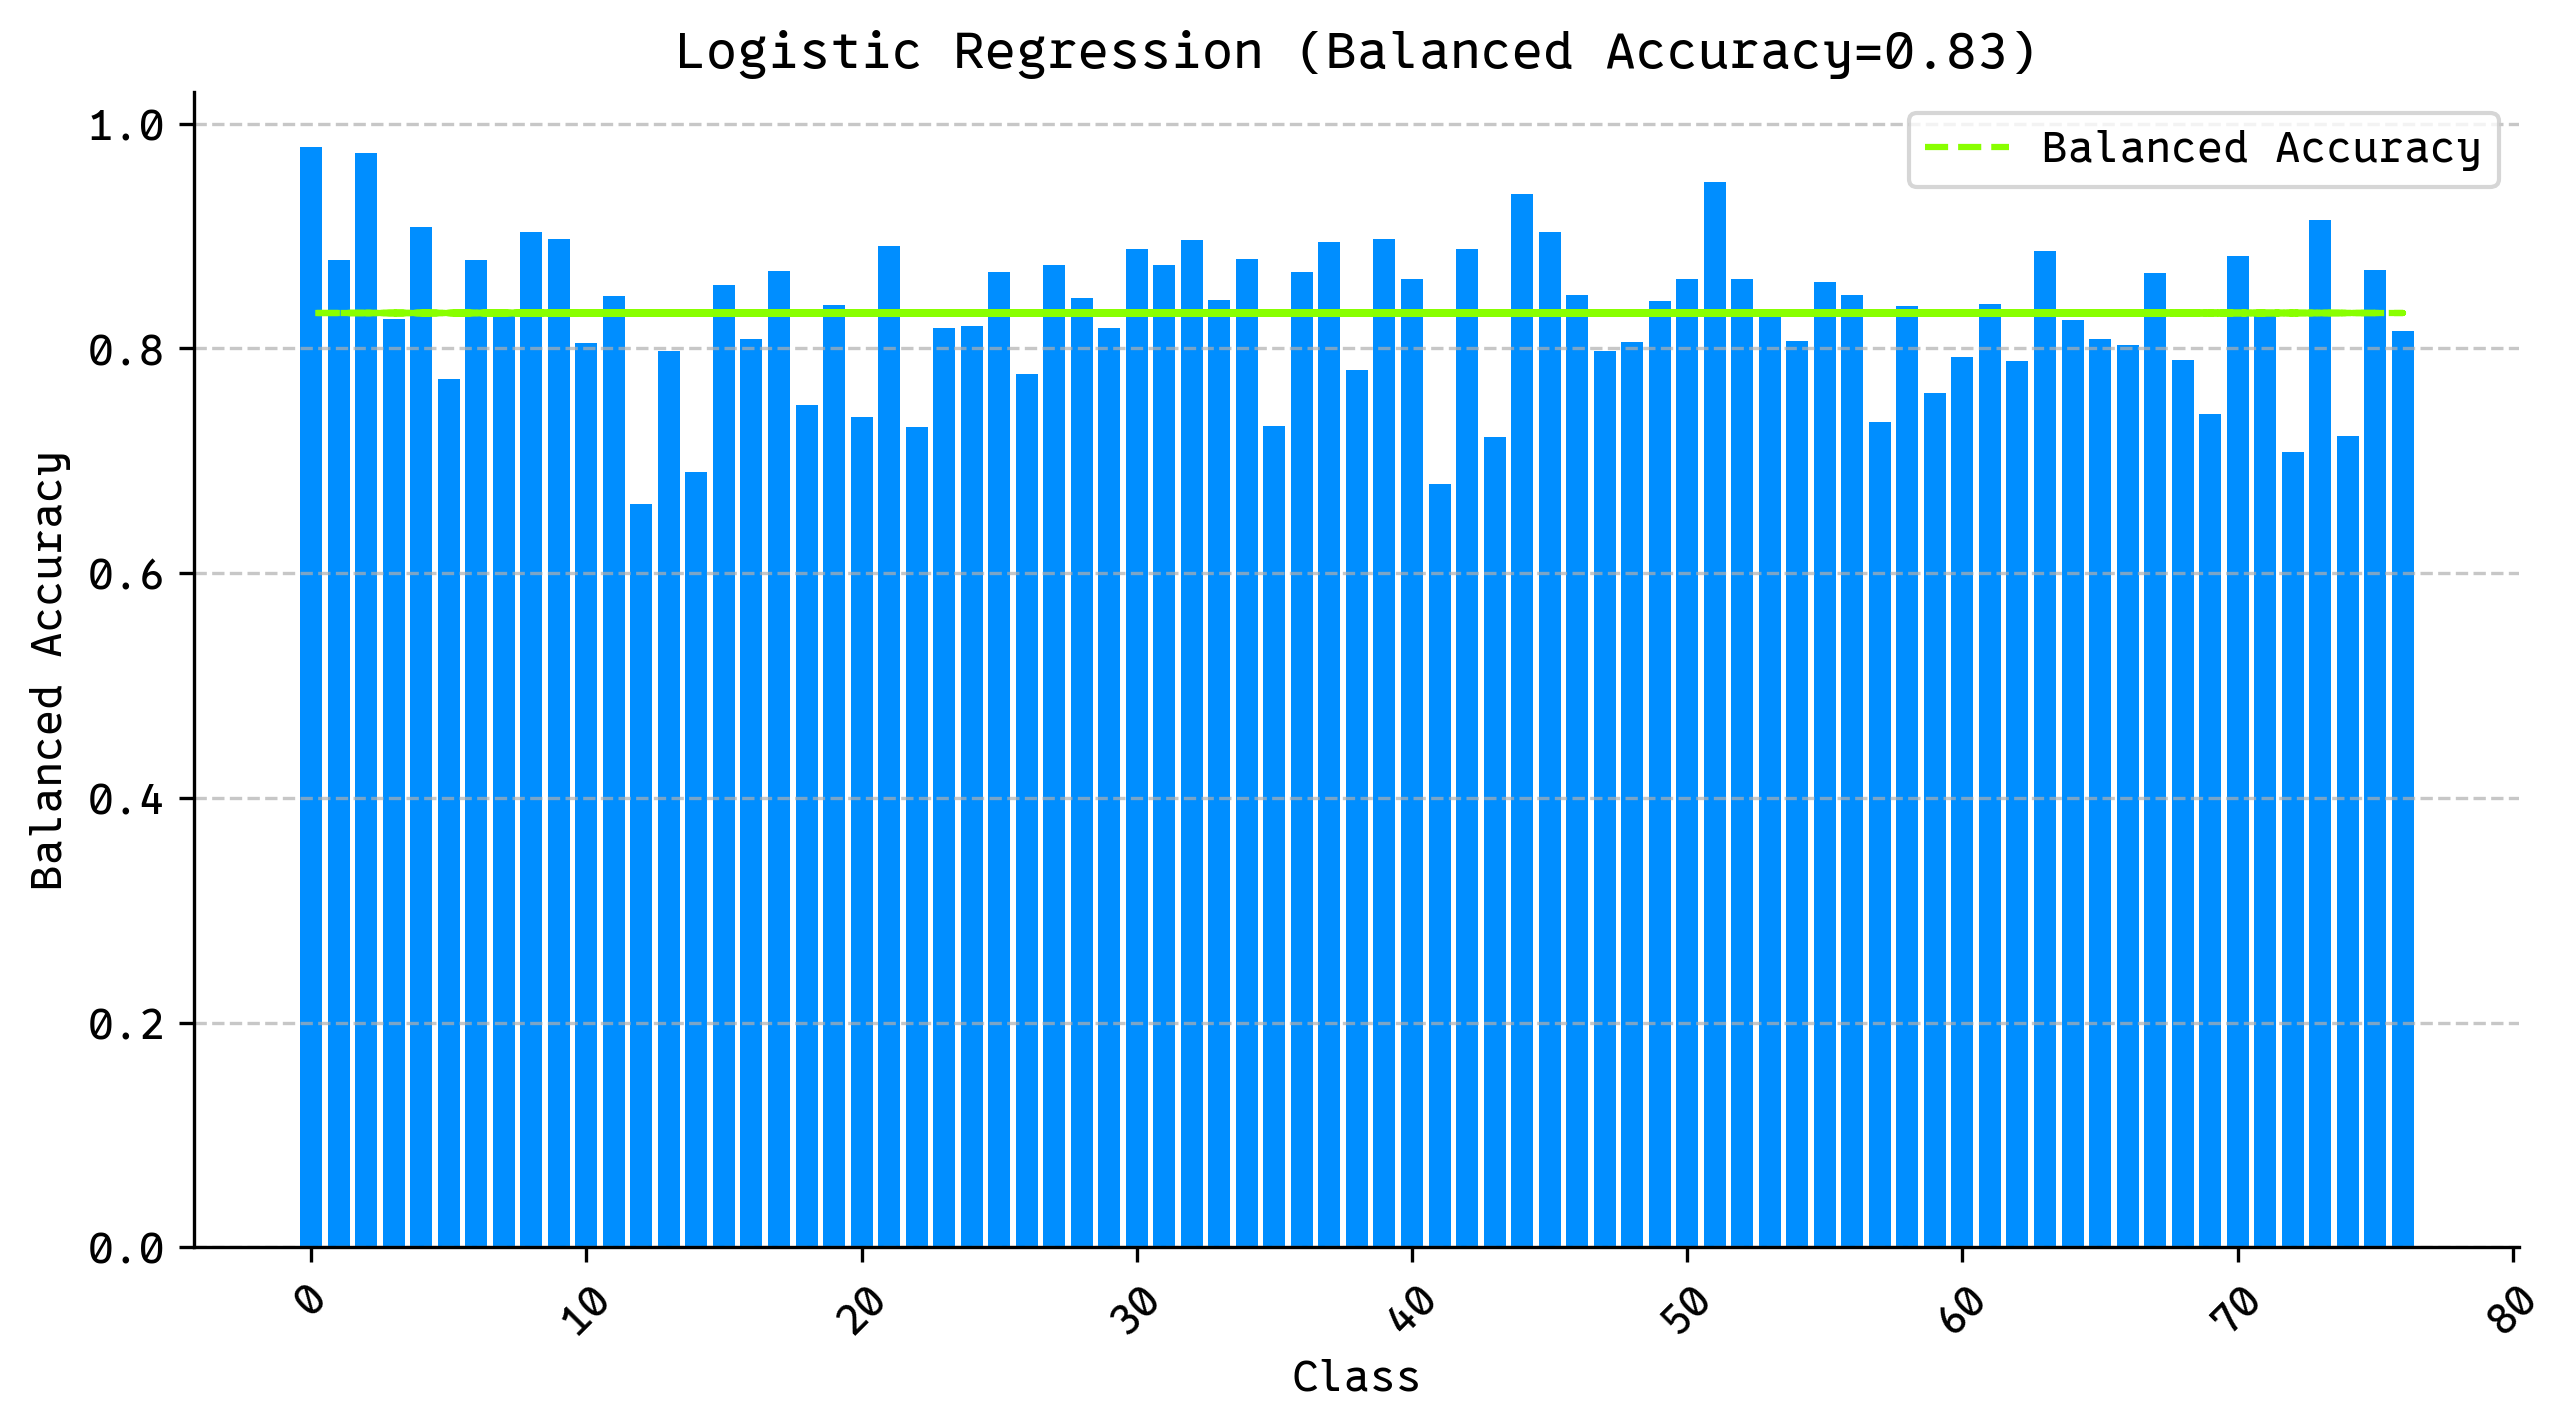

In [4]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'


def plot_performance_across_classes(metrics_df, metric="F1 Score", model_name="Model"):
    """
    Plots the performance of a given metric across all classes.

    Parameters:
    - metrics_df (pd.DataFrame): DataFrame containing metrics for each class.
    - metric (str): The metric to plot (e.g., 'F1 Score', 'Accuracy').
    - model_name (str): The name of the model for the title of the plot.

    Returns:
    - None: Displays the plot.
    """
    # Set font to 0xProto if available
    plt.rcParams["font.family"] = "0xProto"

    # Calculate weighted average of the metric
    weighted_avg_metric = metrics_df[metric].mean()

    # Create the plot
    plt.figure(figsize=(10, 5), dpi=150)
    plt.bar(metrics_df["Class"], metrics_df[metric], color="#008eff")
    plt.plot(
        metrics_df["Class"],
        [weighted_avg_metric] * len(metrics_df),
        color="#89ff00",
        linestyle="--",
        label=f"{metric}",
    )
    plt.xlabel("Class")
    plt.ylabel(metric)
    plt.title(f"{model_name} ({metric}={weighted_avg_metric:.2f})")

    # Disable top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.legend()
    plt.show()


# Plot the F1 Score for each class
plot_performance_across_classes(
    metrics_df=all_metrics_df,
    metric="Balanced Accuracy", 
    model_name="Logistic Regression"
)

## Local Explanation

True label for the instance: 7 (beneficiary_not_allowed)
Class with highest prediction probability: 7 (beneficiary_not_allowed)
Highest prediction probability: 0.9948
Top contributing tokens for class 7:


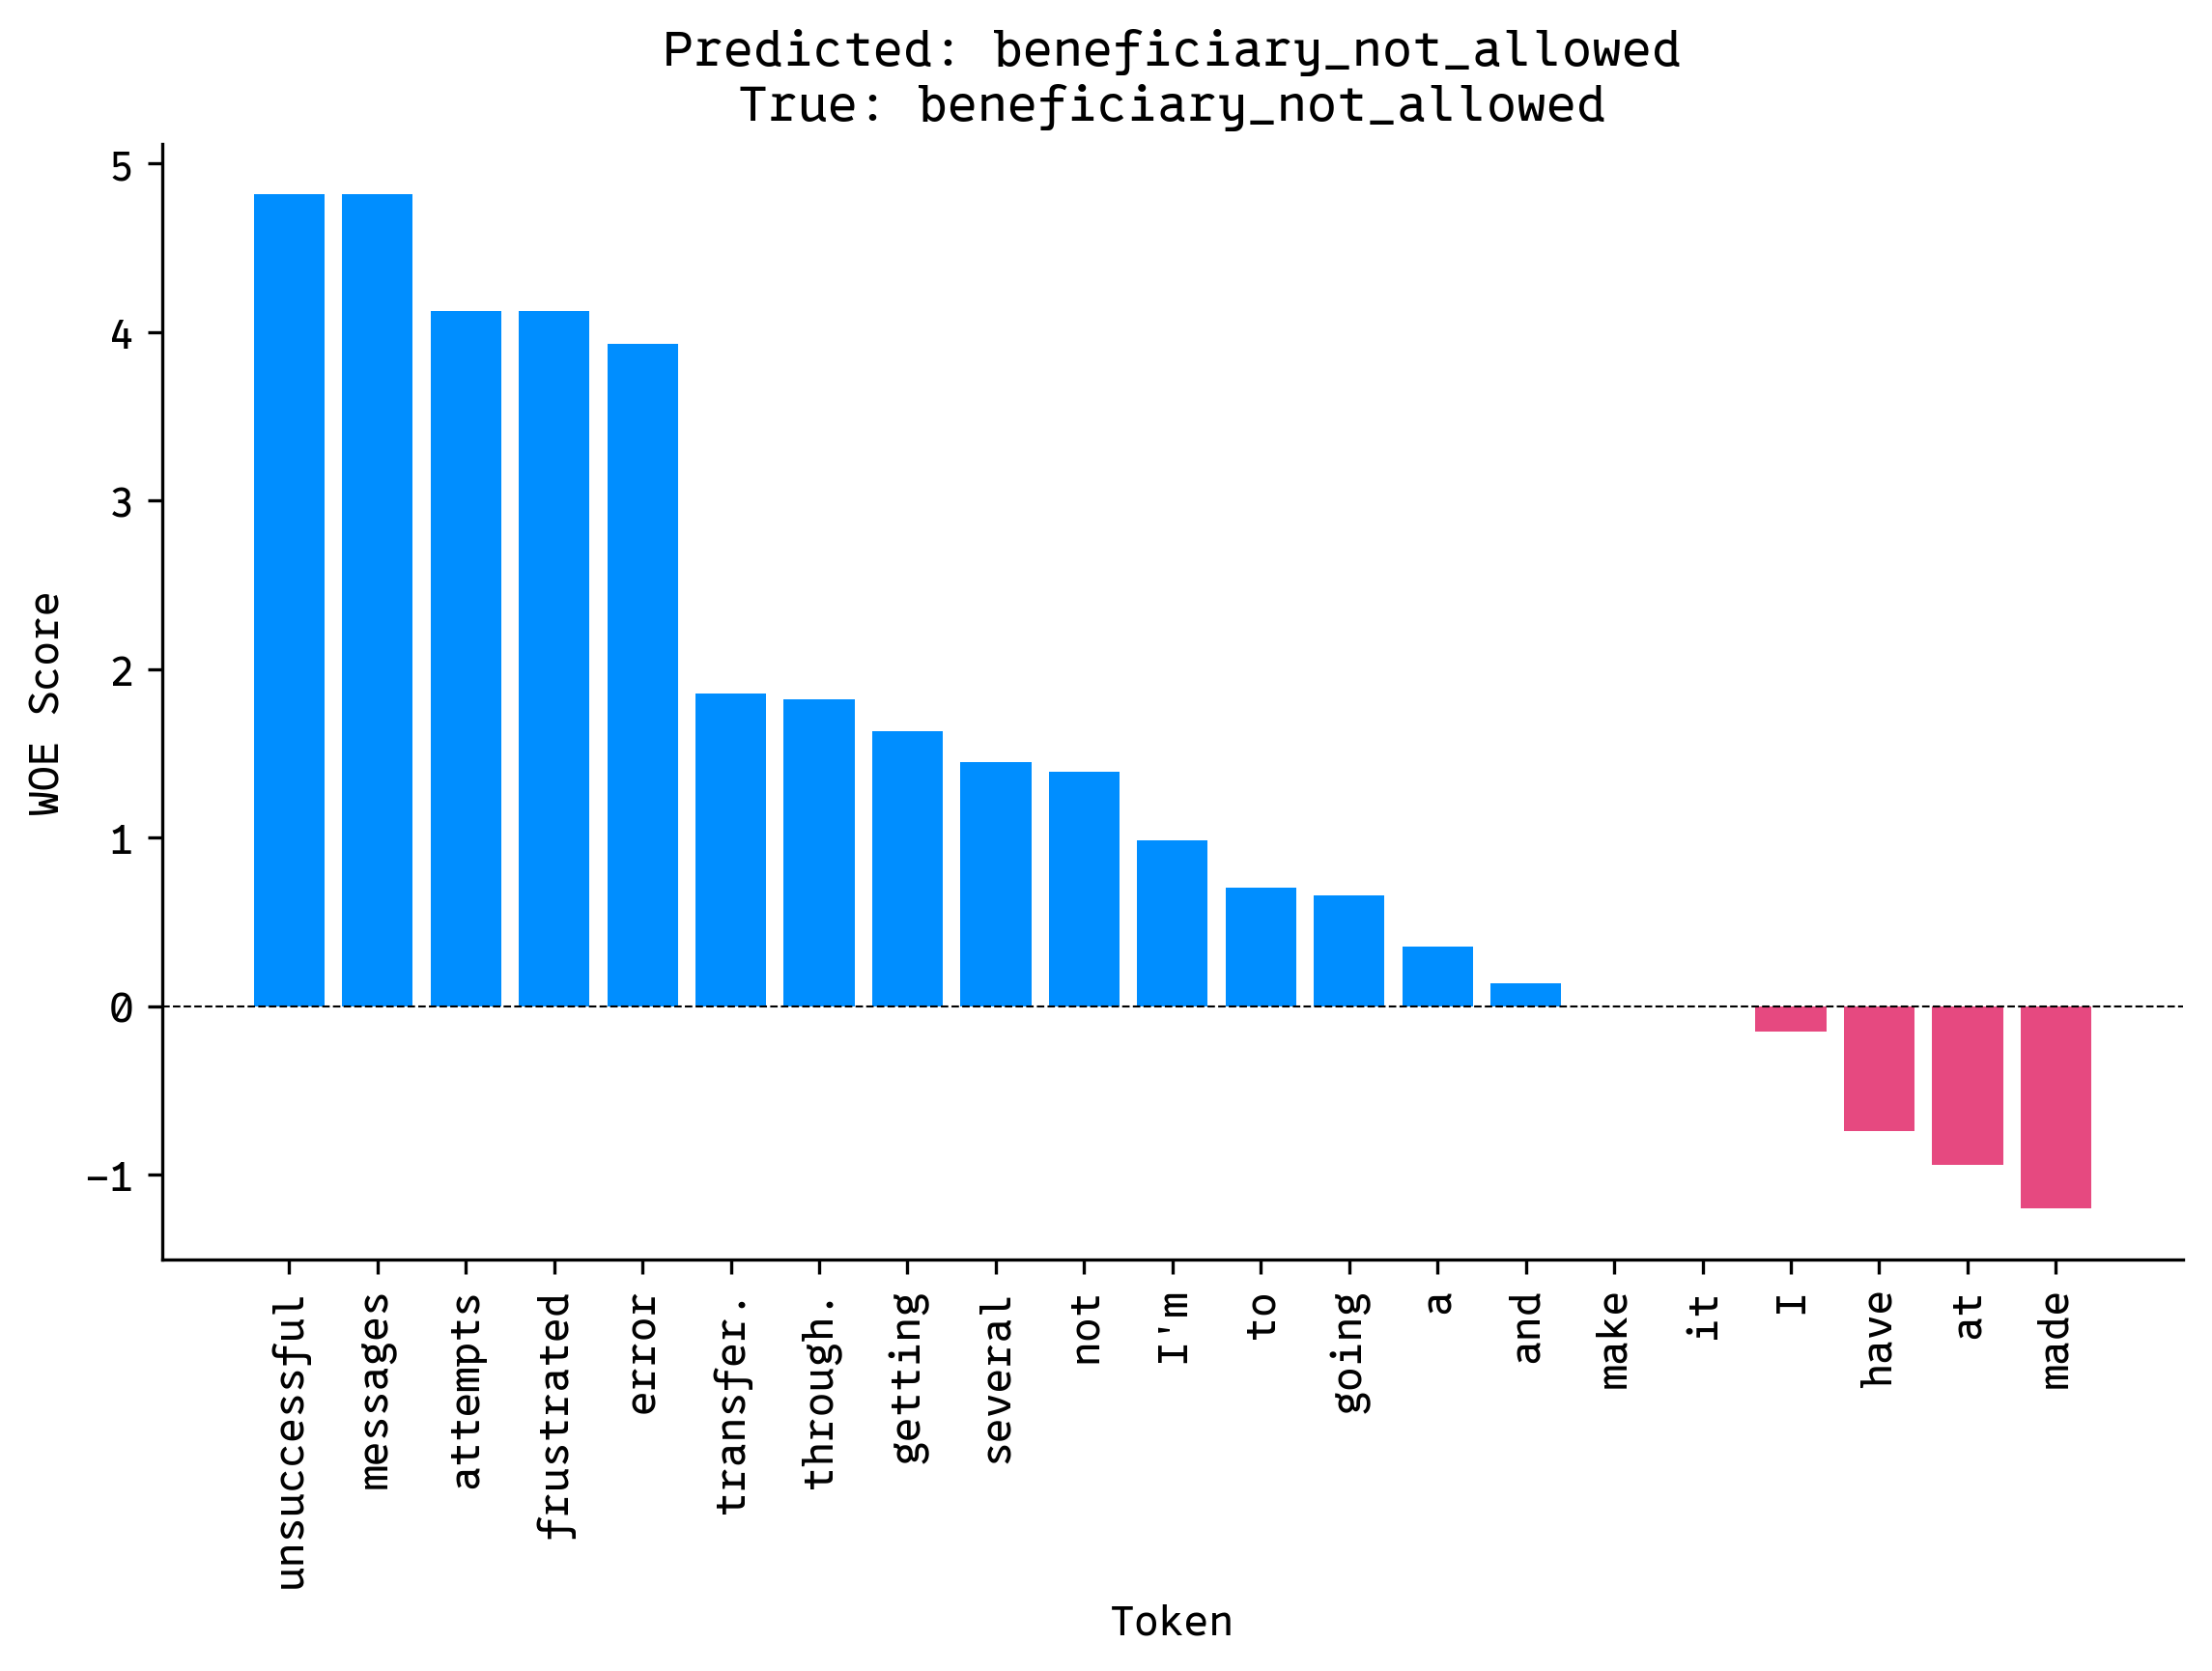

In [5]:
from woe_text_utils import explain_prediction_for_class, plot_woe_contributions, label_to_intent

instance_idx = 1100

# Example usage to explain prediction for a specific instance
explanation_df, class_with_highest_proba = explain_prediction_for_class(
    df=df,
    text_col="text",
    label_col="label",
    classifiers=classifiers,  # Dictionary of classifiers for each class
    woe_mappings=woe_mappings,  # Dictionary storing WOE mappings for each class
    label_to_intent=label_to_intent,  # Pass the label-to-intent mapping (woe_text_utils.py)
    instance_index=instance_idx,  # The index of the instance to explain
)

true_label = df.loc[instance_idx, "label"]
# Plot the WOE contributions for the top tokens for the class with highest probability
plot_woe_contributions(explanation_df, class_with_highest_proba, true_label, label_to_intent)